## Time-harmonic cavity

In [76]:
from fenics import *
from mshr import *
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
%matplotlib inline

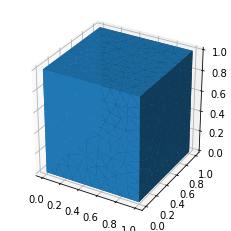

In [77]:
a = 1.0
box = Box(Point(0.0, 0.0, 0.0), Point(a, a, a))
mesh = generate_mesh(box, 16)
plot(mesh)

In [78]:
V = FunctionSpace(mesh, 'N1curl', 1)

# Define variational problem
A = TrialFunction(V)
v = TestFunction(V)

mu = 1.0
a_stiff = (1 / mu)*dot(curl(A), curl(v))*dx
a_mass = dot(A, v)*dx
omega = 1.0
a = a_stiff - (omega**2)*a_mass

### Trivial example to verify validity
$\mathbf{A} = \mathbf{e}_z$ and therefore $\mathbf{j} = -\omega^2 \mathbf{e}_z$ (according to time-harmonic Maxwell equation).

In [79]:
# Set boundary conditions
u_D = Expression(('0.0', '0.0', '1.0'), degree=1)
bc = DirichletBC(V, u_D, 'on_boundary')

J = Expression(('0.0', '0.0', 'j'), degree=1, j=-omega*omega)
L = dot(J, v)*dx

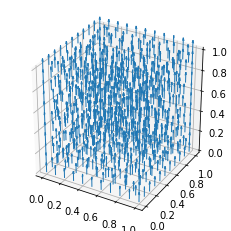

In [80]:
# Solve variational problem
A = Function(V)
solve(a == L, A, bc)

# Plot vector potential
plot(A)

### Export the forms and the field to .txt files

In [81]:
def export_form_as_sparse_matrix(a, fname):
    """
    Export form as sparse matrix.
    
    Format
    ------
    [i, j, a(i, j)]
    
    Reference
    ---------
    https://fenicsproject.org/qa/14194/how-to-dump-fenics-matrix-to-an-text-file-matrix-market-format/
    """
    M = assemble(a)
    Mmat = as_backend_type(M).mat()
    mat = coo_matrix(csr_matrix(Mmat.getValuesCSR()[::-1]))

    np.savetxt(fname + '.txt',
               np.c_[mat.row, mat.col, mat.data],
               fmt = ['%d', '%d', '%.16f']) 

In [82]:
def export_field_at_vertex_coordinates(A, mesh, fname):
    """
    Export vector field evalauted at vertex coordinates.
    
    Format
    ------
    [A_x, A_y, A_z, x, y, z]
    """
    Avec = A.compute_vertex_values(mesh)
    n = int(len(Avec)/3)
    A_x, A_y, A_z = Avec[0*n:1*n], Avec[1*n:2*n], Avec[2*n:3*n]
    
    coords = mesh.coordinates()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    np.savetxt(fname + '.txt',
               np.c_[A_x, A_y, A_z, x, y, z],
               fmt = ['%.16f', '%.16f', '%.16f', '%.16f', '%.16f', '%.16f'])

In [85]:
export_form_as_sparse_matrix(a_stiff, 'a_stiff')
export_form_as_sparse_matrix(a_mass, 'a_mass')
export_field_at_vertex_coordinates(A, mesh, 'A_vertex')